### Описание:
Классифицировать игроков в каждом кадре по двум командам на основе цвета их формы.

### Данные:
Скачайте архив с данными [отсюда](https://disk.yandex.ru/d/NMlVHytktlzbEw) и распакуйте. Внутри архива лежит папка `frames` и файл `bboxes.json`. Файл `bboxes.json` содержит bounding boxes игроков двух команд, а в папке `frames` расположены соответствующие им изображения (кадры). Всего дано 100 кадров. Каждому кадру соответствует 10 bounding boxes игроков.

Структура файла `bboxes.json` следующая:
```
frame_n: {
     player_1: {
             'box': [x,y,w,h],
             'team': int
     }
     .....
     plyaer_10: { .... }
}
....
frame_n+k: { .... }
```
Здесь `frame_n` - номер кадра (ему соответствует файл с изображением в папке frames, всего 100),<br>
`player_1` - id игрока в текущем кадре,<br>
`'box': [x,y,w,h]` - bounding box соответствующего игрока (координаты нормализованы от 0 до 1, поэтому их нужно домножить на размеры изображения, чтобы перевести их в целые координаты фрейма),<br>
`'team': int` - id команды к которой принадлежит игрок  в данном кадре (может принимать значения 0 или 1).
Такм образом, id игроков и id команд имеют смысл только в пределах одного кадра и не связаны с другими кадрами. Т.е. в разных кадрах одному и тому же игроку / команде может соответствовать разные id.

### Задачи:
1) Классифицируйте игроков, используя в качестве вектора признаков игрока (features) средний цвет в пространстве RGB, который берется из области изображения, покрытой bounding box этого игрока (т.е. вектор признаков будет состоять из 3 элементов `[r,g,b]`.<br>
2) Используйте в качестве вектора признаков игроков их средний цвет в пространстве HSV (аналогично вектор признаков `[h,s,v]`.<br>
3) Используйте в качестве вектора признаков гистограмму в пространстве RGB, а не средний цвет. Число бинов определите самостоятельно.<br>
4) Используйте в качестве вектора признаков гистограмму в пространстве HSV.

### Как классифицировать:
В качестве классификатора можете использовать:
- Методы без обучения: k-means (на 2 кластера) или другие методы кластеризации.
- Методы с обучением: K-Nearest Neighbors, RandomForest, GaussianNB или др.

### Результаты:
1. Посчитайте точность классификации для четырех задач и сравните результаты. 
2. Задание будет принято, если итоговая точность будет выше чем 0.5 (рекорд на данный момент - 0.82)

## Решение

In [93]:
import os
import json
import pandas as pd
import numpy as np
import cv2
from typing import List, Tuple
import torchvision.transforms as transforms
import albumentations as A

import matplotlib.pyplot as plt

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [143]:
DATA_PATH = "../team_classification_data/"

In [144]:
# Reload the JSON file

def json2df(path):
    df = pd.read_json(path)
    flattened_data = []
    for id_key in df.columns:
        column_data = df[id_key].dropna().tolist()
        for item in column_data:
            item['frame_id'] = id_key
            flattened_data.append(item)
    return pd.DataFrame(flattened_data)

# Display the first few rows of the flattened DataFrame
df = json2df(os.path.join(DATA_PATH, 'bboxes.json'))

In [145]:
#Add column with image size
df['im_size'] = None
for i, row in df.iterrows():
    img_path = os.path.join(DATA_PATH, 'frames', str(row['frame_id'])+'.jpeg')
    image = cv2.imread(img_path)
    im_size = image.shape[:-1]
    df.at[i, 'im_size'] = im_size

df.head(2)

,box,team,frame_id,im_size
0,"[0.11533481077263101, 0.35555271172804304, 0.0...",0,1310,"(720, 1280)"
1,"[0.681131806806146, 0.43534840337278, 0.102315...",0,1310,"(720, 1280)"


In [146]:
bboxes_abs_params = []

for _, row in df.iterrows():
    height, width = row['im_size']
    b_x, b_y, b_width, b_height =  row['box']
    x_min = int(b_x * width)
    y_min = int(b_y * height)
    x_max = int((b_x + b_width) * width)
    y_max = int((b_y + b_height) * height)
    bboxes_abs_params.append([x_min, y_min, x_max, y_max])
    
df[['x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(bboxes_abs_params, index=df.index)

df['x_min'] = df['x_min'].abs()

df = df.reset_index()
df.rename(columns={'index': 'b_index'}, inplace=True)
df.head(2)

,b_index,box,team,frame_id,im_size,x_min,y_min,x_max,y_max
0,0,"[0.11533481077263101, 0.35555271172804304, 0.0...",0,1310,"(720, 1280)",147,255,229,408
1,1,"[0.681131806806146, 0.43534840337278, 0.102315...",0,1310,"(720, 1280)",871,313,1002,534


In [147]:
#Function to visualize images with bboxes
def draw_bboxes(unique_images: List[str], datapath: str, folder: str, df: pd.DataFrame, figsize: Tuple[int, int] = (15, 5), plot_row: int = 2, plot_col: int = 2):
    plt.figure(figsize=figsize)
    for i, image_file in enumerate(unique_images):
        img_path = os.path.join(datapath, folder, str(image_file)+'.jpeg')
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Filter dataframe for the current image
        image_data = df[df['frame_id'] == image_file]

        # Plot each bounding box
        for _, row in image_data.iterrows():
            if row['team']== 0:
                cv2.rectangle(image, (row.x_min, row.y_min), (row.x_max, row.y_max), (255, 0, 0), 2)
            else:
                cv2.rectangle(image, (row.x_min, row.y_min), (row.x_max, row.y_max), (0, 0, 255), 2)
            cv2.putText(image, str(row['team']), (row.x_min, row.y_max), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

        # Create subplot for each image
        ax = plt.subplot(plot_row, plot_col, i + 1)
        ax.set_title(image_file, fontsize = 7)
        ax.imshow(image)
        ax.axis('off')
        
    plt.tight_layout()
    plt.show()

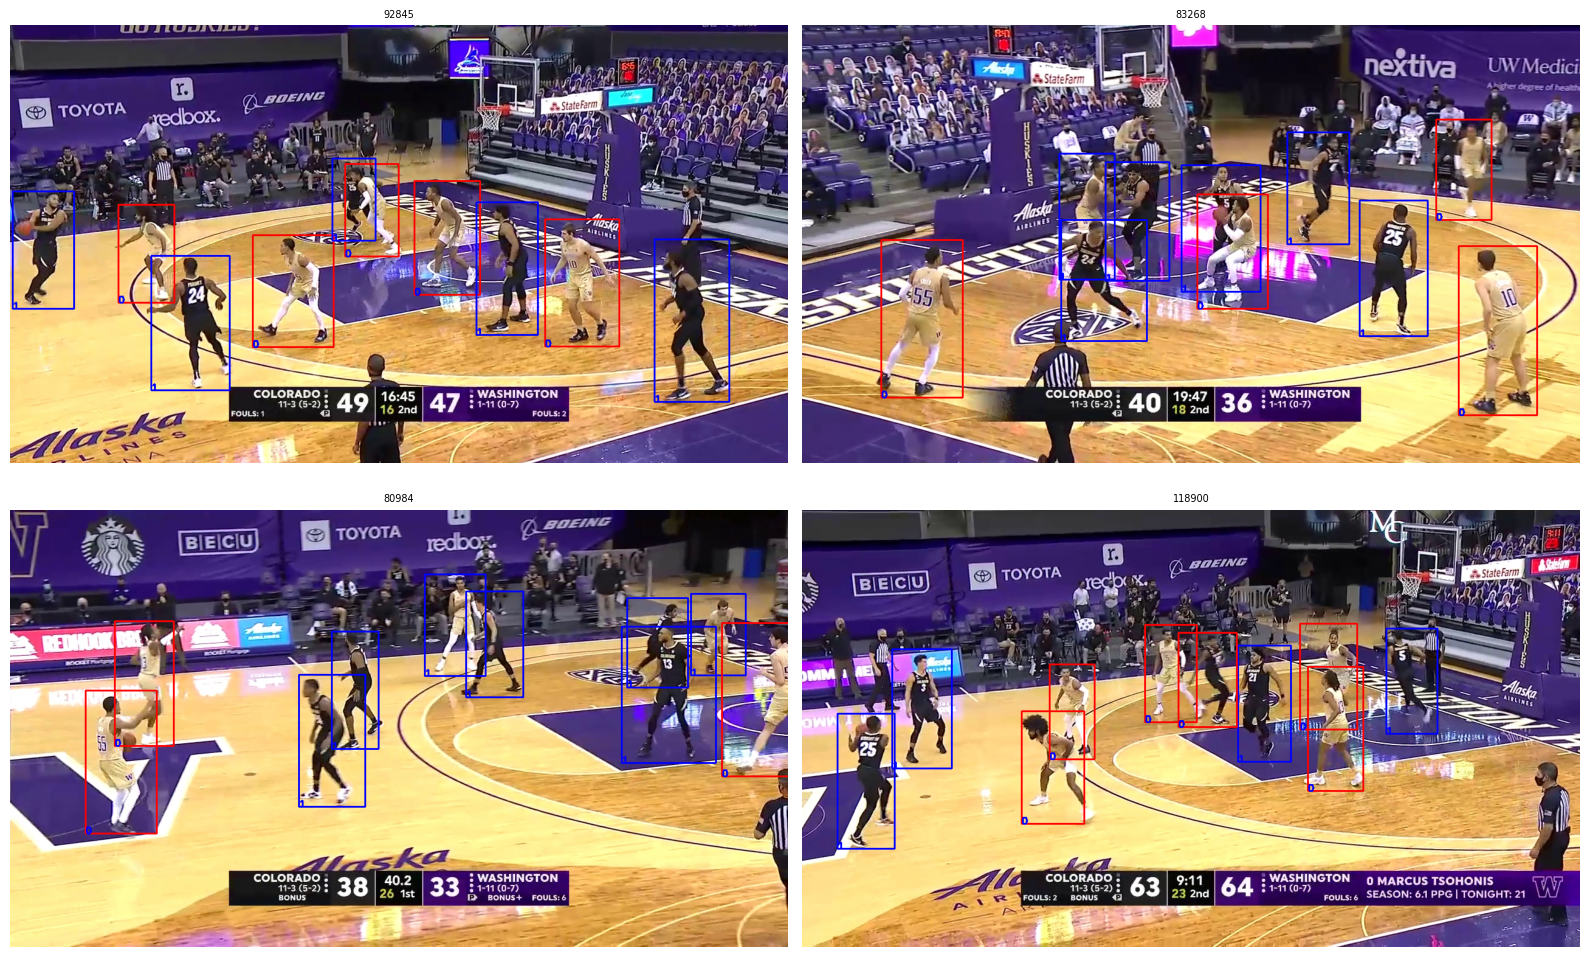

In [148]:
NUM_IMAGES = 2 * 2
unique_images = np.random.choice(df['frame_id'].unique(), NUM_IMAGES, replace=False)
draw_bboxes(unique_images, datapath=DATA_PATH, df=df, folder='frames', figsize=(16, 10))

In [100]:
os.makedirs(f'{DATA_PATH}/bboxes/0', exist_ok=True)
os.makedirs(f'{DATA_PATH}/bboxes/1', exist_ok=True)

In [101]:
#Cut and save crops of bboxes
images_list = df['frame_id'].unique()

for image_name in images_list:
    image = cv2.imread(os.path.join(DATA_PATH, 'frames', f'{image_name}.jpeg'))[..., ::-1]
    image_data = df[df['frame_id'] == image_name]
    for i, row in image_data.iterrows():
        x1 = row['x_min']
        y1 = row['y_min']
        x2 = row['x_max']
        y2 = row['y_max']
        crop = image[y1:y2, x1:x2]
        cv2.imwrite(os.path.join(DATA_PATH, 'bboxes', str(row['team']), f"{image_name}_{row['team']}_{row['b_index']}.jpeg"), crop)

In [102]:
def shifted_center_crop(image, crop_height, crop_width, shift_x, shift_y):
    height, width = image.shape[:2]
    center_x, center_y = width // 2, height // 2
    top_left_x = max(0, center_x - crop_width // 2 + shift_x)
    top_left_y = max(0, center_y - crop_height // 2 + shift_y)

    if top_left_x + crop_width > width:
        top_left_x = width - crop_width
    if top_left_y + crop_height > height:
        top_left_y = height - crop_height

    return image[top_left_y:top_left_y + crop_height, top_left_x:top_left_x + crop_width]

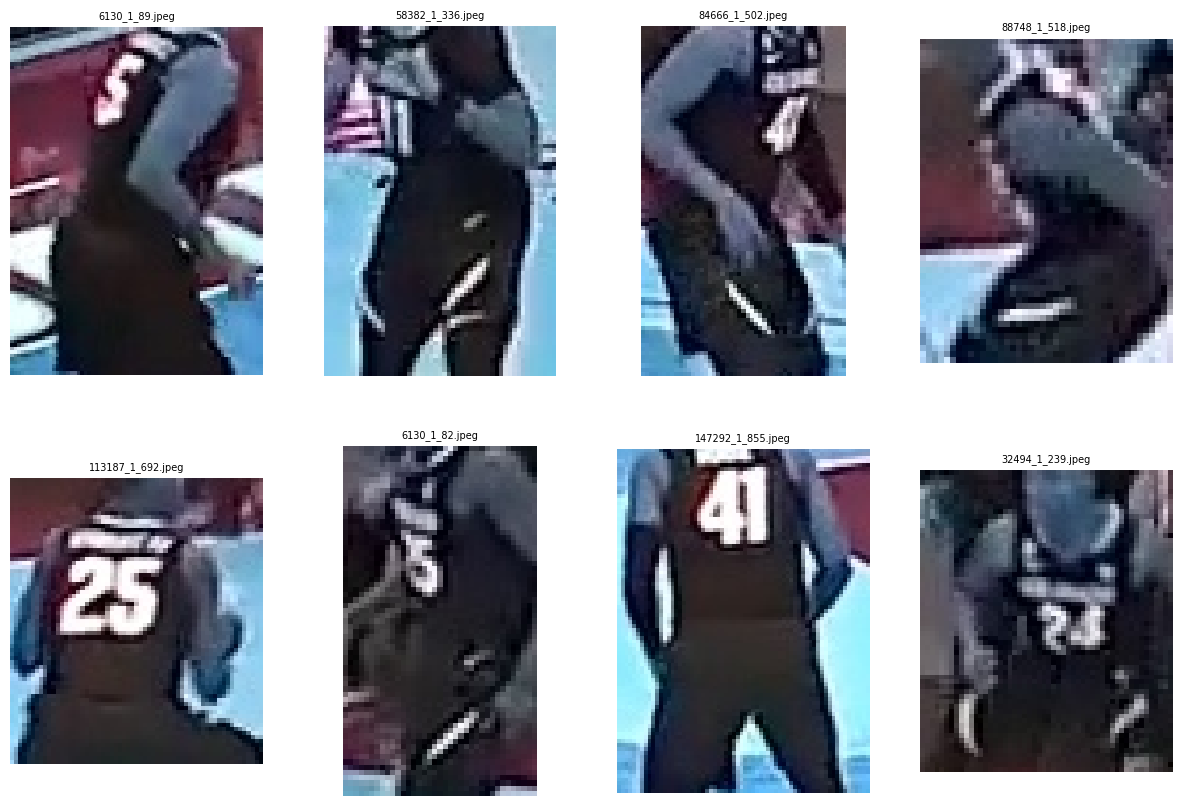

In [149]:
#Visualize image bboxes
DIR_1 = os.path.join(DATA_PATH, 'bboxes/0')
DIR_2 = os.path.join(DATA_PATH, 'bboxes/1')

image_data = []

ramdom_images = np.random.choice(os.listdir(DIR_2), 8, replace=False)

plt.figure(figsize=(15, 10))
for i, image_path in enumerate(ramdom_images):
    image = cv2.imread(os.path.join(DIR_2, image_path))[..., ::-1]
    height, width = image.shape[:2]
    
    cropped_image = shifted_center_crop(image, int(height*0.45), int(width*0.6), shift_x = 0, shift_y = -18)
    ax = plt.subplot(2, 4, i + 1)
    ax.set_title(image_path, fontsize = 7)
    ax.imshow(cropped_image)
    ax.axis('off')
        

In [150]:
#Create dataframe with bboxes features
#Visualize image bboxes

DIR_BBOXES = os.path.join(DATA_PATH, 'bboxes')

columns = ['bbox_name', 'team', 'r','g','b', 'h','s','v', 'gray']
teams = [0,1]
image_data = []

SHIFT_Y = -18
CROP_HEIGHT = 0.5
CROP_WIDTH = 0.6

for team in teams:
    for dirpath, _, filenames in os.walk(os.path.join(DIR_BBOXES, str(team))):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirpath, filename))[..., ::-1]
            height, width = image.shape[:2]
            cropped_image = shifted_center_crop(image, int(height*CROP_HEIGHT), int(width*CROP_WIDTH), shift_x = 0, shift_y=SHIFT_Y)
            cropped_image_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2HSV)
            cropped_image_gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)
            r = cropped_image[..., 0].mean()
            g = cropped_image[..., 1].mean()
            b = cropped_image[..., 2].mean()
            h = cropped_image_hsv[..., 0].mean()
            s = cropped_image_hsv[..., 1].mean()
            v = cropped_image_hsv[..., 2].mean()
            gray = cropped_image_gray.mean()
            image_data.append([filename, team, r,g,b,h,s,v, gray])
            
df_mean_colors = pd.DataFrame(image_data , columns=columns )

df_mean_colors.head()

,bbox_name,team,r,g,b,h,s,v,gray
0,34889_0_255.jpeg,0,102.775537,107.654707,124.050408,123.578354,72.225945,125.553744,108.062713
1,81183_0_474.jpeg,0,126.806312,130.978820,156.723499,118.325744,100.779943,168.802182,132.662395
2,110751_0_683.jpeg,0,119.333111,162.626783,199.318405,107.907308,115.989528,201.973708,153.849599
3,89418_0_523.jpeg,0,104.956522,117.364257,137.731294,120.235844,83.347321,140.145602,115.969161
4,14063_0_116.jpeg,0,116.870875,176.060943,210.480303,101.378451,115.858081,210.480303,162.272222


<Axes: >

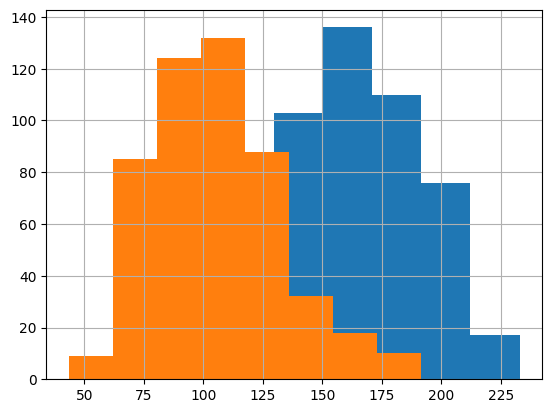

In [152]:
df_mean_colors[df_mean_colors['team']==0]['v'].hist(bins=8)
df_mean_colors[df_mean_colors['team']==1]['v'].hist(bins=8)

In [106]:
hist_bins_list = [6, 8, 16]
teams = [0, 1]
df_dict = {}

for hist_bins in hist_bins_list:
    # columns = ['bbox_name', 'team'] + [f'r_bin_{i}' for i in range(hist_bins)] + [f'g_bin_{i}' for i in range(hist_bins)] + [f'b_bin_{i}' for i in range(hist_bins)] + [f'h_bin_{i}' for i in range(hist_bins)] + [f's_bin_{i}' for i in range(hist_bins)] + [f'v_bin_{i}' for i in range(hist_bins)] + [f'gray_bin_{i}' for i in range(hist_bins)]

    columns = ['bbox_name', 'team'] + [f'r_bin_{i}' for i in range(hist_bins)] + [f'g_bin_{i}' for i in range(hist_bins)] + [f'b_bin_{i}' for i in range(hist_bins)] + [f'h_bin_{i}' for i in range(hist_bins)] + [f's_bin_{i}' for i in range(hist_bins)] + [f'v_bin_{i}' for i in range(hist_bins)]
    image_data = []

    for team in teams:
        for dirpath, _, filenames in os.walk(os.path.join(DIR_BBOXES, str(team))):
            for filename in filenames:
                image = cv2.imread(os.path.join(dirpath, filename))
                if image is not None:
                    height, width = image.shape[:2]
                    area = height * width

                    cropped_image = shifted_center_crop(image, int(height*CROP_HEIGHT), int(width*CROP_WIDTH), shift_x = 0, shift_y=SHIFT_Y)
                    cropped_image_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)
                    # cropped_image_gray = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2GRAY)

                    # Рассчитываем гистограммы
                    r_hist = cv2.calcHist([cropped_image], [0], None, [hist_bins], [0, 256]).flatten()
                    g_hist = cv2.calcHist([cropped_image], [1], None, [hist_bins], [0, 256]).flatten()
                    b_hist = cv2.calcHist([cropped_image], [2], None, [hist_bins], [0, 256]).flatten()
                    h_hist = cv2.calcHist([cropped_image_hsv], [0], None, [hist_bins], [0, 180]).flatten()
                    s_hist = cv2.calcHist([cropped_image_hsv], [1], None, [hist_bins], [0, 256]).flatten()
                    v_hist = cv2.calcHist([cropped_image_hsv], [2], None, [hist_bins], [0, 256]).flatten()
                    # gray_hist = cv2.calcHist([cropped_image_gray], [0], None, [hist_bins], [0, 256]).flatten()

                    # Нормализуем гистограммы
                    r_hist = r_hist / area
                    g_hist = g_hist / area
                    b_hist = b_hist / area
                    h_hist = h_hist / area
                    s_hist = s_hist / area
                    v_hist = v_hist / area
                    gray_hist = gray_hist / area

                    # Добавляем данные в список
                    image_data.append([filename, team] + r_hist.tolist() + g_hist.tolist() + b_hist.tolist() + h_hist.tolist() + s_hist.tolist() + v_hist.tolist())
                    
    df_dict[hist_bins] = pd.DataFrame(image_data, columns=columns)

df_6_bins = df_dict[6]
df_8_bins = df_dict[8]
df_16_bins = df_dict[16]

In [107]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import mode
from sklearn.metrics import accuracy_score
import lightgbm as lgb

In [130]:
# Разделение данных на признаки и метки
SEED=19
TEST_SIZE = 0.1
split_data = {}

# Function to split data and add to dictionary
def add_splits_to_dict(df, feature_name, split_data, test_size, x_columns=None, random_state=42):
    if x_columns:
        X = df[x_columns]
    else:
        X = df.drop(columns=['bbox_name', 'team'], axis=1)
    y = df['team']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state, shuffle=True, stratify=y)
    split_data[feature_name] = {'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}

# Add splits for RGB and HSV
add_splits_to_dict(df_mean_colors, 'rgb', split_data,  test_size=TEST_SIZE, x_columns=['r','g','b'], random_state=SEED)
add_splits_to_dict(df_mean_colors, 'hsv', split_data, test_size=TEST_SIZE, x_columns=['h','s','v'],  random_state=SEED)
add_splits_to_dict(df_mean_colors, 'gray', split_data, test_size=TEST_SIZE, x_columns=['gray'], random_state=SEED)

for hist_bins in df_dict:
    add_splits_to_dict(df_dict[hist_bins], f'hist_{hist_bins}_all', split_data, test_size=TEST_SIZE, random_state=SEED)
    columns_rgb = [f'r_bin_{i}' for i in range(hist_bins)] + [f'g_bin_{i}' for i in range(hist_bins)] + [f'b_bin_{i}' for i in range(hist_bins)]
    columns_hsv = [f'h_bin_{i}' for i in range(hist_bins)] + [f's_bin_{i}' for i in range(hist_bins)] + [f'v_bin_{i}' for i in range(hist_bins)]
    add_splits_to_dict(df_dict[hist_bins], f'hist_{hist_bins}_rgb', split_data, x_columns=columns_rgb,  test_size=TEST_SIZE, random_state=SEED)
    add_splits_to_dict(df_dict[hist_bins], f'hist_{hist_bins}_hsv', split_data, x_columns=columns_hsv,  test_size=TEST_SIZE, random_state=SEED)

In [131]:
# Access the data as follows:
split_data['hist_8_rgb']['y_train'].value_counts()

team
0    452
1    448
Name: count, dtype: int64

In [132]:
split_data.keys()

dict_keys(['rgb', 'hsv', 'gray', 'hist_6_all', 'hist_6_rgb', 'hist_6_hsv', 'hist_8_all', 'hist_8_rgb', 'hist_8_hsv', 'hist_16_all', 'hist_16_rgb', 'hist_16_hsv'])

In [133]:
# Function to map K-means clusters to actual class labels
def map_clusters_to_labels(cluster_labels, actual_labels):
    label_mapping = {}
    unique_clusters = np.unique(cluster_labels)
    for cluster in unique_clusters:
        indices = np.where(cluster_labels == cluster)[0]
        cluster_actual_labels = actual_labels.iloc[indices]
        most_common_label = mode(cluster_actual_labels).mode
        label_mapping[cluster] = most_common_label
    return label_mapping

In [135]:
classifiers = {
    'K-Means': KMeans(n_clusters=2, random_state=SEED),
    'KNN': KNeighborsClassifier(n_neighbors=8),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'SVM': SVC(kernel='poly', gamma='scale', C=0.1, random_state=SEED),
    'LGBM': lgb.LGBMClassifier(num_leaves=50, n_estimators=120, learning_rate=0.05,random_state=SEED, verbose= -100)
}



# Modified train_and_evaluate function
def train_and_evaluate(feature_name, X_train, X_test, y_train, y_test):
    results = []
    for clf_name, clf in tqdm(classifiers.items(), desc=f'Training {feature_name}'):
        if clf_name == 'K-Means':
            # Special handling for K-means
            clf.fit(X_train)
            train_clusters = clf.predict(X_train)
            cluster_label_mapping = map_clusters_to_labels(train_clusters, y_train)
            test_clusters = clf.predict(X_test)
            y_pred = np.array([cluster_label_mapping[cluster] for cluster in test_clusters])
        else:
            # Standard supervised learning classifiers
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        results.append([feature_name, clf_name, accuracy])
    return results


# Train and evaluate each dataset
overall_results = []

for feature_name, data in split_data.items():
    dataset_results = train_and_evaluate(feature_name, **data)
    overall_results.extend(dataset_results)

results_df = pd.DataFrame(overall_results, columns=['Feature Set', 'Classifier', 'Accuracy'])

results_df.sort_values(by='Accuracy',ascending=False)

Training hist_16_hsv: 100%|██████████| 5/5 [00:00<00:00,  6.11it/s]


,Feature Set,Classifier,Accuracy
48,hist_16_all,SVM,0.92
18,hist_6_all,SVM,0.92
38,hist_8_rgb,SVM,0.92
16,hist_6_all,KNN,0.92
33,hist_8_all,SVM,0.92
46,hist_16_all,KNN,0.92
42,hist_8_hsv,Random Forest,0.91
32,hist_8_all,Random Forest,0.91
28,hist_6_hsv,SVM,0.91
26,hist_6_hsv,KNN,0.91


In [113]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to compute mean vectors for each class
def compute_class_mean_vectors(X_train, y_train):
    class_mean_vectors = {}
    unique_classes = np.unique(y_train)

    for cls in unique_classes:
        class_data = X_train[y_train == cls]
        class_mean_vectors[cls] = np.mean(class_data, axis=0)

    return class_mean_vectors

# Function to classify using cosine similarity
def classify_cosine_similarity(sample, class_mean_vectors):
    max_similarity = -1
    predicted_class = None

    for cls, mean_vector in class_mean_vectors.items():
        similarity = cosine_similarity([sample], [mean_vector])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            predicted_class = cls

    return predicted_class

def train_and_evaluate_cosine_similarity(X_train, X_test, y_train, y_test):
    class_mean_vectors = compute_class_mean_vectors(X_train, y_train)
    y_pred = [classify_cosine_similarity(sample, class_mean_vectors) for sample in X_test.values]
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [72]:
classifiers = {
    'Cosine Similarity': 'Cosine Similarity',
    'SVM': SVC(kernel='poly', gamma='scale', random_state=SEED),
    'Gradient Boosting': lgb.LGBMClassifier(num_leaves=50, n_estimators=120, learning_rate=0.05,random_state=SEED, verbose= -100),
    'Random Forest': RandomForestClassifier(random_state=SEED),
    'KNN': KNeighborsClassifier(n_neighbors=6),
}

# Define hyperparameter grids for each classifier
param_grids = {
    'KNN': {'n_neighbors': [4, 5, 6, 7, 8]},
    'Random Forest': {'n_estimators': [100, 150, 200], 'max_depth': [10, 20, None]},
    'SVM': {'C': [0.1, 1, 10, 100], 'gamma':['scale'], 'kernel': ['linear', 'rbf', 'poly']},
    'Gradient Boosting': {'num_leaves': [31, 41, 51], 'n_estimators': [100, 120, 150, 200], 'learning_rate': [0.05, 0.1],}
}

# Modified train_and_evaluate function
def train_and_evaluate(feature_name, X_train, X_test, y_train, y_test):
    results = []

    for clf_name, clf in classifiers.items():
        if clf_name == 'Cosine Similarity':
            best_score = train_and_evaluate_cosine_similarity(X_train, X_test, y_train, y_test)
            best_params = None
            
        elif clf_name == 'K-Means':
            # Special handling for K-means
            clf.fit(X_train)
            train_clusters = clf.predict(X_train)
            cluster_label_mapping = map_clusters_to_labels(train_clusters, y_train)
            test_clusters = clf.predict(X_test)
            y_pred = np.array([cluster_label_mapping[cluster] for cluster in test_clusters])
            best_score = accuracy_score(y_test, y_pred)
            best_params = None
        
        else:
            if clf_name in param_grids:
                # Perform GridSearchCV to find the best parameters (without cross-validation)
                grid_search = GridSearchCV(clf, param_grids[clf_name], cv=None, scoring='accuracy')
                grid_search.fit(X_train, y_train)
                best_clf = grid_search.best_estimator_
                y_pred = best_clf.predict(X_test)
                best_params = grid_search.best_params_
            else:
                # Standard training and evaluation for classifiers without hyperparameter tuning
                clf.fit(X_train, y_train)
                y_pred = clf.predict(X_test)
                best_params = None
            best_score = accuracy_score(y_test, y_pred)
        
        results.append([feature_name, clf_name, best_params, best_score])
        
    return results

overall_results = []

for feature_name, data in split_data.items():
    if 'hist' in feature_name:
        dataset_results = train_and_evaluate(feature_name, **data)
        overall_results.extend(dataset_results)

results_df = pd.DataFrame(overall_results, columns=['Feature Set', 'Classifier', 'Best Params', 'Accuracy'])

results_df.sort_values(by='Accuracy',ascending=False)

,Feature Set,Classifier,Best Params,Accuracy
29,hist_8_hsv,KNN,{'n_neighbors': 8},0.935
4,hist_6_all,KNN,{'n_neighbors': 6},0.935
9,hist_6_rgb,KNN,{'n_neighbors': 8},0.935
16,hist_8_all,SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.925
32,hist_16_all,Gradient Boosting,"{'learning_rate': 0.05, 'n_estimators': 100, '...",0.925
28,hist_8_hsv,Random Forest,"{'max_depth': 20, 'n_estimators': 150}",0.925
27,hist_8_hsv,Gradient Boosting,"{'learning_rate': 0.05, 'n_estimators': 120, '...",0.925
36,hist_16_rgb,SVM,"{'C': 0.1, 'gamma': 'scale', 'kernel': 'poly'}",0.925
1,hist_6_all,SVM,"{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}",0.925
37,hist_16_rgb,Gradient Boosting,"{'learning_rate': 0.05, 'n_estimators': 200, '...",0.925


In [137]:
##Calculation of best model
X_train, X_test, y_train, y_test  = split_data['hist_8_all'].values()

results = []

clf_best = SVC(kernel='poly', gamma='scale', C=0.1, random_state=SEED)
clf_best.fit(X_train, y_train)
y_pred = clf_best.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

accuracy

0.92

## Расчет на тестовой выборке

In [200]:
df_test = pd.read_json(os.path.join(DATA_PATH, 'test_bboxes.json'))
df_test.head(14)

,1407,2119,2163,2200,2693,2697,2804,6165,6528,6611,...,147622,148147,148312,153058,153133,153162,154090,154127,165754,170874
0,"{'box': [-0.0015210441069250001, 0.43708349041...","{'box': [0.7270851734022911, 0.443313527117331...","{'box': [0.5600106669547861, 0.457001726746976...","{'box': [0.38332591506451, 0.410621596591402, ...","{'box': [0.381770475704773, 0.4742020613538010...","{'box': [0.383500269406825, 0.4638890540317800...","{'box': [0.443980952334014, 0.451863432537123,...","{'box': [0.7051862058449331, 0.353187501598088...","{'box': [0.220014542270274, 0.5271998110909261...","{'box': [0.07289615848004201, 0.41687757936755...",...,"{'box': [0.416341627142055, 0.322373845548914,...","{'box': [0.7057448639476701, 0.426532408607743...","{'box': [0.336505793004901, 0.3910768880199540...","{'box': [0.358615846338374, 0.3908673092854630...","{'box': [0.17052865177283202, 0.35953084876394...","{'box': [0.13867887378832802, 0.36467864001679...","{'box': [0.08428057601864801, 0.31640103932231...","{'box': [0.350856527234491, 0.3094017673765150...","{'box': [0.13898800944051, 0.40728507571015404...","{'box': [0.563413992551915, 0.3778785283644730..."
1,"{'box': [0.709295994263159, 0.301092835844955,...","{'box': [0.66080786761842, 0.5067854357058671,...","{'box': [0.642548995557365, 0.3175407242969960...","{'box': [0.73216717537286, 0.366261312169365, ...","{'box': [0.26865463400892103, 0.51549804791527...","{'box': [0.285003672056972, 0.5119495607578071...","{'box': [0.44477809165449506, 0.53383225844546...","{'box': [0.473808676054063, 0.325011778864909,...","{'box': [0.36998602398627, 0.35675577897715405...","{'box': [0.5991330496500901, 0.271139520336424...",...,"{'box': [0.7538943440751, 0.338012985678854, 0...","{'box': [0.26371735395495605, 0.42238769070851...","{'box': [0.7606162133717961, 0.468628941329951...","{'box': [0.38678946962085603, 0.45691079085200...","{'box': [0.07455446067356, 0.40989009159002604...","{'box': [0.06347480467517701, 0.47272448811332...","{'box': [0.420615808918522, 0.29227039415889, ...","{'box': [0.11645486847422801, 0.36327897380687...","{'box': [0.22993245145551702, 0.31732783353225...","{'box': [0.137509934399698, 0.277994517758114,..."
2,"{'box': [0.46132630712513406, 0.41996624607376...","{'box': [0.625530757766194, 0.301782420520173,...","{'box': [0.285384411957017, 0.5295594329812501...","{'box': [0.28204995975817504, 0.59675028979253...","{'box': [0.07869667407689601, 0.37506238247536...","{'box': [0.079210252917345, 0.3730971409796170...","{'box': [0.296618859965035, 0.295094509427826,...","{'box': [0.9331261798588011, 0.353256243433619...","{'box': [0.316087805545812, 0.384660222030936,...","{'box': [0.5556737956232041, 0.348499917374303...",...,"{'box': [0.197385816919733, 0.3711709370320830...","{'box': [0.123492055744033, 0.4253716402663730...","{'box': [0.333096072924483, 0.3299187016758320...","{'box': [0.482934803737862, 0.25384512033943, ...","{'box': [0.44224458299280006, 0.22133053007255...","{'box': [0.44083097190556003, 0.23077756737005...","{'box': [0.11934492131718001, 0.31487617504126...","{'box': [0.178528911833109, 0.4734434010193590...","{'box': [0.456014810148589, 0.2124156674242170...","{'box': [0.6299676018182121, 0.446473896505548..."
3,"{'box': [0.26243106544542705, 0.49965433527406...","{'box': [0.6938061516486901, 0.25943671710964,...","{'box': [0.8135721155257921, 0.537161357013465...","{'box': [0.78688990810209, 0.535917955496748, ...","{'box': [0.25588723616479403, 0.35639342023256...","{'box': [0.24511600502215602, 0.35442453134261...","{'box': [0.405668835764525, 0.312429340913293,...","{'box': [0.544177362979197, 0.313917421923875,...","{'box': [0.8890919504605521, 0.345204822102126...","{'box': [0.22494738839729403, 0.27193339784526...",...,"{'box': [0.6280847842782911, 0.402382424282742...","{'box': [0.43487589236294305, 0.23562496338227...","{'box': [0.372876900329948, 0.341667987730122,...","{'box': [0.406497892426244, 0.179261635055801,...","{'

In [203]:
DATA_PATH = "../team_classification_test/"
# Reload the JSON file
def json2df(path):
    df = pd.read_json(path)
    flattened_data = []
    for frame_id in df.columns:
        bboxes = df[frame_id].dropna().to_dict()
        for bbox_number, bbox_data in bboxes.items():
            bbox_data['frame_id'] = frame_id
            bbox_data['bbox_number'] = bbox_number
            flattened_data.append(bbox_data)
    return pd.DataFrame(flattened_data)

# Display the first few rows of the flattened DataFrame
df_test = json2df(os.path.join(DATA_PATH, 'test_bboxes.json'))
df_test.head(5)

,box,frame_id,bbox_number
0,"[-0.0015210441069250001, 0.43708349041354205, ...",1407,0
1,"[0.709295994263159, 0.301092835844955, 0.06710...",1407,1
2,"[0.46132630712513406, 0.41996624607376004, 0.0...",1407,2
3,"[0.26243106544542705, 0.49965433527406505, 0.0...",1407,3
4,"[0.6367493960785301, 0.403939177584881, 0.1037...",1407,4


In [204]:
#Add column with image size
df_test['im_size'] = None
for i, row in df_test.iterrows():
    img_path = os.path.join(DATA_PATH, 'frames', str(row['frame_id'])+'.jpeg')
    image = cv2.imread(img_path)
    im_size = image.shape[:-1]
    df_test.at[i, 'im_size'] = im_size

df_test.head(2)

,box,frame_id,bbox_number,im_size
0,"[-0.0015210441069250001, 0.43708349041354205, ...",1407,0,"(720, 1280)"
1,"[0.709295994263159, 0.301092835844955, 0.06710...",1407,1,"(720, 1280)"


In [205]:
bboxes_abs_params = []

for _, row in df_test.iterrows():
    height, width = row['im_size']
    b_x, b_y, b_width, b_height =  row['box']
    x_min = int(abs(b_x) * width)
    y_min = int(abs(b_y) * height)
    x_max = int((abs(b_x) + b_width) * width)
    y_max = int((abs(b_y) + b_height) * height)
    bboxes_abs_params.append([x_min, y_min, x_max, y_max])
    
df_test[['x_min', 'y_min', 'x_max', 'y_max']] = pd.DataFrame(bboxes_abs_params, index=df_test.index)

df_test['x_min'] = df_test['x_min'].abs()


,b_index,box,frame_id,bbox_number,im_size,x_min,y_min,x_max,y_max
0,0,"[-0.0015210441069250001, 0.43708349041354205, ...",1407,0,"(720, 1280)",1,314,79,505
1,1,"[0.709295994263159, 0.301092835844955, 0.06710...",1407,1,"(720, 1280)",907,216,993,405


In [174]:
os.makedirs(f'{DATA_PATH}/bboxes', exist_ok=True)

In [206]:
#Cut and save crops of bboxes
images_list = df_test['frame_id'].unique()

for image_name in images_list:
    image = cv2.imread(os.path.join(DATA_PATH, 'frames', f'{image_name}.jpeg'))[..., ::-1]
    image_data = df_test[df_test['frame_id'] == image_name]
    for i, row in image_data.iterrows():
        x1 = row['x_min']
        y1 = row['y_min']
        x2 = row['x_max']
        y2 = row['y_max']
        crop = image[y1:y2, x1:x2]
        cv2.imwrite(os.path.join(DATA_PATH, 'bboxes', f"{image_name}_{row['bbox_number']}.jpeg"), crop)

In [210]:
import re
DIR_BBOXES_TEST='../team_classification_test/bboxes'
hist_bins_list = [8]
df_test_dict = {}

for hist_bins in hist_bins_list:
    columns = ['frame'] +  ['bbox_num'] + [f'r_bin_{i}' for i in range(hist_bins)] + [f'g_bin_{i}' for i in range(hist_bins)] + [f'b_bin_{i}' for i in range(hist_bins)] + [f'h_bin_{i}' for i in range(hist_bins)] + [f's_bin_{i}' for i in range(hist_bins)] + [f'v_bin_{i}' for i in range(hist_bins)]
    image_data = []

    for dirpath, _, filenames in os.walk(DIR_BBOXES_TEST):
        for filename in filenames:
            image = cv2.imread(os.path.join(dirpath, filename))
            if image is not None:
                height, width = image.shape[:2]
                area = height * width

                cropped_image = shifted_center_crop(image, int(height*CROP_HEIGHT), int(width*CROP_WIDTH), shift_x = 0, shift_y=SHIFT_Y)
                cropped_image_hsv = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2HSV)

                # Рассчитываем гистограммы
                r_hist = cv2.calcHist([cropped_image], [0], None, [hist_bins], [0, 256]).flatten()
                g_hist = cv2.calcHist([cropped_image], [1], None, [hist_bins], [0, 256]).flatten()
                b_hist = cv2.calcHist([cropped_image], [2], None, [hist_bins], [0, 256]).flatten()
                h_hist = cv2.calcHist([cropped_image_hsv], [0], None, [hist_bins], [0, 180]).flatten()
                s_hist = cv2.calcHist([cropped_image_hsv], [1], None, [hist_bins], [0, 256]).flatten()
                v_hist = cv2.calcHist([cropped_image_hsv], [2], None, [hist_bins], [0, 256]).flatten()

                # Нормализуем гистограммы
                r_hist = r_hist / area
                g_hist = g_hist / area
                b_hist = b_hist / area
                h_hist = h_hist / area
                s_hist = s_hist / area
                v_hist = v_hist / area

                # Добавляем данные в список
                image_data.append([filename.split('_')[0]] + [filename.split('_')[1].split('.')[0]] + r_hist.tolist() + g_hist.tolist() + b_hist.tolist() + h_hist.tolist() + s_hist.tolist() + v_hist.tolist())
                    
    df_8_bins = pd.DataFrame(image_data, columns=columns)

df_8_bins.head()

,frame,bbox_num,r_bin_0,r_bin_1,r_bin_2,r_bin_3,r_bin_4,r_bin_5,r_bin_6,r_bin_7,...,s_bin_6,s_bin_7,v_bin_0,v_bin_1,v_bin_2,v_bin_3,v_bin_4,v_bin_5,v_bin_6,v_bin_7
0,8570,7,0.052881,0.088118,0.044601,0.027648,0.013602,0.026908,0.016608,0.024247,...,0.005027,0.007935,0.027894,0.095362,0.049628,0.038884,0.014193,0.025381,0.016411,0.026859
1,95722,9,0.039034,0.048384,0.023874,0.033769,0.033769,0.020243,0.054466,0.040577,...,0.003540,0.009804,0.022513,0.053468,0.031681,0.037400,0.033769,0.020243,0.054466,0.040577
2,147595,2,0.046374,0.092198,0.033077,0.022912,0.037363,0.030165,0.011374,0.023242,...,0.003736,0.010549,0.021813,0.111593,0.019945,0.037198,0.039451,0.030824,0.011703,0.024176
3,140417,9,0.041117,0.082354,0.052805,0.027152,0.014924,0.013426,0.027811,0.036922,...,0.011928,0.026253,0.037881,0.080796,0.047950,0.032246,0.017981,0.014145,0.027691,0.037821
4,147622,2,0.007841,0.021868,0.010161,0.013971,0.026009,0.030040,0.035949,0.149373,...,0.003700,0.005080,0.006295,0.014026,0.018996,0.014302,0.025899,0.030261,0.036059,0.149373


In [215]:
##best model test prediction
features = df_8_bins.columns
features = features.drop(['frame',	'bbox_num'])

df_8_bins['predicted_class'] = df_8_bins[features].apply(lambda x: clf_best.predict([x.values])[0], axis=1)

In [226]:
df_result = df_8_bins[['frame', 'bbox_num', 'predicted_class']].sort_values(by=['frame','bbox_num'])
df_result.head(5)

,frame,bbox_num,predicted_class
957,100017,0,0
811,100017,1,0
239,100017,2,0
11,100017,3,1
438,100017,4,0


In [228]:
# Convert DataFrame to the desired JSON format

RESULT_PATH='../team_classification_test/team_color_results_test.json'

output_json = {}
for _, row in df_result.iterrows():
    frame = str(row['frame'])
    bbox_num = str(row['bbox_num'])
    team = int(row['predicted_class'])  # Convert to Python int

    if frame not in output_json:
        output_json[frame] = {}
    output_json[frame][bbox_num] = {"team": team}
    
with open(RESULT_PATH, 'w') as file:
    json.dump(output_json, file, indent=2)
